# HIT140 A3 — Clean Inline Notebook (Investigation A & B)

**Weeks 1–9 compliant; inline outputs only.**  
Place `dataset1.csv` and `dataset2.csv` in the **same folder** as this notebook, or edit the paths below.


In [ ]:
# location of datasets
DATASET1_PATH = 'dataset1.csv'
DATASET2_PATH = 'dataset2.csv'

print('dataset1:', DATASET1_PATH)
print('dataset2:', DATASET2_PATH)

dataset1: dataset1.csv
dataset2: dataset2.csv


In [ ]:
# import libraries

# for basic mathematical operations
import math

# for handling arrays
import numpy as np

# for handling datasets
import pandas as pd

# for visualization
import matplotlib.pyplot as plt

# for linear regression
HAVE_SKLEARN = False
HAVE_STATSMODELS = False
try:
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler, PowerTransformer
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    HAVE_SKLEARN = True
except Exception:
    pass

try:
    import statsmodels.api as sm
    HAVE_STATSMODELS = True
except Exception:
    pass

print('Libraries imported successfully')

Libraries imported successfully


In [ ]:
# === HELPERS ===
# These utility functions modularise common EDA and regression analysis tasks,
# supporting clarity, maintainability, and scientific reproducibility.

def cast_numeric(df, columns):
    """Safely cast listed columns to numeric (coerce errors to NaN)."""
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def add_intercept(X):
    return np.column_stack([np.ones(len(X)), X])

def numpy_ols(y, X, feature_names):
    """Multiple Linear Regression via NumPy least squares."""
    if X.size == 0 or y.size == 0:
        print('Empty X or y.'); 
        return None
    data_concat = np.column_stack([y] + [X[:, i] for i in range(X.shape[1])])
    row_mask = ~np.isnan(data_concat).any(axis=1)
    y_clean = y[row_mask].astype(float)
    X_clean = X[row_mask, :].astype(float)
    if len(y_clean) < X_clean.shape[1] + 2:
        print('Insufficient rows to fit model.'); 
        return None
    Xd = add_intercept(X_clean)
    beta, residuals, rank, s = np.linalg.lstsq(Xd, y_clean, rcond=None)
    y_hat = Xd @ beta
    ss_res = np.sum((y_clean - y_hat) ** 2)
    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')
    n = len(y_clean); p = X_clean.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else float('nan')
    rmse = math.sqrt(ss_res / n) if n > 0 else float('nan')
    coef_df = pd.DataFrame({'term': ['intercept'] + feature_names, 'coefficient': beta.tolist()})
    return {'beta': beta, 'r2': r2, 'adj_r2': adj_r2, 'rmse': rmse, 'n': n, 'p': p, 'yhat': y_hat, 'y': y_clean, 'coef_df': coef_df}

def show_correlation_heatmap(df, cols, title='Correlation heatmap'):
    if len(cols) < 2:
        print('Need >= 2 columns for a correlation heatmap.'); 
        return
    corr = df[cols].corr()
    print('Correlation matrix:')
    display(corr)
    plt.figure()
    plt.imshow(corr.values, aspect='auto')
    plt.xticks(range(len(cols)), cols, rotation=30, ha='right')
    plt.yticks(range(len(cols)), cols)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_coef_bar(coef_df, title='Coefficients'):
    df = coef_df[coef_df['term'] != 'intercept'].copy()
    if df.empty:
        print('No coefficients (other than intercept) to display.'); 
        return
    plt.figure()
    plt.bar(df['term'], df['coefficient'])
    plt.title(title); plt.ylabel('Coefficient')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout(); plt.show()

def show_residual_hist(residuals, title='Residuals', xlabel='Residual'):
    plt.figure()
    plt.hist(residuals, bins=30)
    plt.title(title); plt.xlabel(xlabel)
    plt.tight_layout(); plt.show()

def show_fitted_vs_observed(y_hat, y, title='Fitted vs Observed'):
    plt.figure()
    plt.scatter(y_hat, y, s=12)
    plt.title(title); plt.xlabel('Fitted'); plt.ylabel('Observed')
    plt.tight_layout(); plt.show()

## 1) Load & Clean

In [ ]:
# Read data
dataset1 = pd.read_csv('dataset1.csv')
dataset2 = pd.read_csv('dataset2.csv')


# Datetime casting
# Convert time columns with day first style
for col in ['start_time', 'rat_period_start', 'rat_period_end', 'sunset_time']:
    if col in dataset1.columns:
        dataset1[col] = pd.to_datetime(dataset1[col], errors='coerce', dayfirst=True)

if 'time' in dataset2.columns:
    dataset2['time'] = pd.to_datetime(dataset2['time'], errors='coerce', dayfirst=True)


# Numeric casting
dataset1 = cast_numeric(dataset1, ['bat_landing_to_food','seconds_after_rat_arrival','hours_after_sunset','risk','reward'])
dataset2 = cast_numeric(dataset2, ['bat_landing_number','food_availability','rat_minutes','rat_arrival_number','hours_after_sunset'])

print('Dataset 1 — Data Types:')
display(dataset1.dtypes.to_frame('dtype').T)
print('\n')
print('Dataset 2 — data Types:')
display(dataset2.dtypes.to_frame('dtype').T)

Dataset 1 — Data Types:


C:\Users\Subhash Chauhan\AppData\Local\Temp\ipykernel_3252\1232726136.py:10: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dataset1[col] = pd.to_datetime(dataset1[col], errors='coerce', dayfirst=True)
C:\Users\Subhash Chauhan\AppData\Local\Temp\ipykernel_3252\1232726136.py:10: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dataset1[col] = pd.to_datetime(dataset1[col], errors='coerce', dayfirst=True)
C:\Users\Subhash Chauhan\AppData\Local\Temp\ipykernel_3252\1232726136.py:10: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dataset1[col] = pd.to_datetime(dataset1[col], errors='coerce', dayfirst=True)
C:\Users\Subhash Chauhan\AppData\Local\Temp\ipykernel_3252\12

,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
dtype,datetime64[ns],float64,object,datetime64[ns],datetime64[ns],int64,int64,int64,int64,datetime64[ns],float64,int64




Dataset 2 — data Types:


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
dtype,datetime64[ns],int64,float64,int64,float64,float64,int64


## 2) Time-aware Merge (±30 minutes)

In [ ]:
# === TIME-AWARE MERGE BETWEEN DATASETS ===
# Combine bat (dataset1) and rat (dataset2) records based on their timestamps.
# This uses a ±30-minute tolerance to match the nearest rat observation for each bat event.
# The merge_asof approach is appropriate when both datasets are time-ordered and observations

# Check that both time columns exist before attempting the merge
if 'start_time' in dataset1.columns and 'time' in dataset2.columns:

    # Sort datasets by time to satisfy merge_asof() requirements
    dataset1_sorted = dataset1.sort_values('start_time')
    dataset2_sorted = dataset2.sort_values('time')

    # Perform a time-aware (nearest) merge within a 30-minute tolerance window
    merged_df = pd.merge_asof(
        dataset1_sorted,
        dataset2_sorted[
            ['time', 'rat_minutes', 'rat_arrival_number',
             'bat_landing_number', 'food_availability', 'hours_after_sunset']
        ].sort_values('time'),
        left_on='start_time',      # main timestamp from dataset1 (bat events)
        right_on='time',           # timestamp from dataset2 (rat blocks)
        direction='nearest',       # match nearest observation (before or after)
        tolerance=pd.Timedelta('30min')  # maximum time difference allowed
    )

    # Create a flag showing which rows successfully found a matching rat block
    merged_df['has_block_match'] = merged_df['time'].notna()

# If one or both timestamp columns are missing, fall back to a simpler merge
else:
    print('Time-aware merge skipped — missing start_time/time columns. '
          'Falling back to simple merge on shared keys if available.')

    # Try to merge using common contextual columns (e.g., month, hours_after_sunset)
    shared_keys = [c for c in ['month', 'hours_after_sunset']
                   if c in dataset1.columns and c in dataset2.columns]

    if shared_keys:
        # Perform a standard key-based merge if common keys exist
        merged_df = pd.merge(dataset1, dataset2, on=shared_keys, how='left')
    else:
        # If no merge keys exist, continue with dataset1 only to preserve workflow
        merged_df = dataset1.copy()

# Display merge results for verification
print('Merged shape:', merged_df.shape)  # shows number of rows × columns after merge
display(merged_df.head(5))               # preview first 5 rows for sanity check


Merged shape: (906, 19)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset_x,season,time,rat_minutes,rat_arrival_number,bat_landing_number,food_availability,hours_after_sunset_y,has_block_match
0,2017-12-26 20:57:00,1.0,unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,239,0,0,0,2017-12-26 16:43:00,4.248611,0,2017-12-26 20:43:00,1.283333,2,51,2.968874,4.0,True
1,2017-12-26 20:57:00,5.0,unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,199,0,0,0,2017-12-26 16:43:00,4.237500,0,2017-12-26 20:43:00,1.283333,2,51,2.968874,4.0,True
2,2017-12-26 21:24:00,3.0,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,121,0,1,0,2017-12-26 16:43:00,4.693611,0,2017-12-26 21:13:00,4.866667,1,53,2.561404,4.5,True
3,2017-12-26 21:24:00,15.0,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,88,1,0,0,2017-12-26 16:43:00,4.684444,0,2017-12-26 21:13:00,4.866667,1,53,2.561404,4.5,True
4,2017-12-26 21:24:00,6.0,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,113,0,1,0,2017-12-26 16:43:00,4.691389,0,2017-12-26 21:13:00,4.866667,1,53,2.561404,4.5,True


## 3) EDA & Multicollinearity Check

Target: bat_landing_to_food | Predictors: ['rat_minutes', 'rat_arrival_number', 'food_availability', 'bat_landing_number']
Correlation matrix:


,rat_minutes,rat_arrival_number,food_availability,bat_landing_number
rat_minutes,1.000000,0.421695,-0.070872,-0.182713
rat_arrival_number,0.421695,1.000000,-0.002841,-0.108188
food_availability,-0.070872,-0.002841,1.000000,0.025157
bat_landing_number,-0.182713,-0.108188,0.025157,1.000000


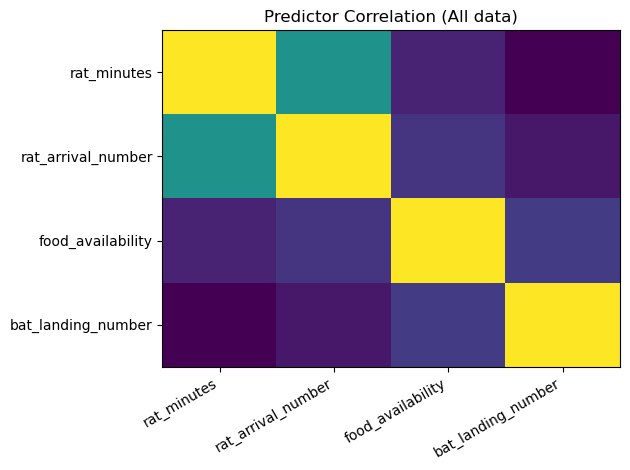

In [ ]:
# Target and predictors
target_var = 'bat_landing_to_food'
candidate_predictors = ['rat_minutes','rat_arrival_number','hours_after_sunset','food_availability','bat_landing_number']
predictor_cols = [c for c in candidate_predictors if c in merged_df.columns]

print('Target:', target_var, '| Predictors:', predictor_cols)
if target_var not in merged_df.columns:
    print('Warning: target variable not found in merged data.')

# Correlation heatmap for predictors
if len(predictor_cols) >= 2:
    show_correlation_heatmap(merged_df, predictor_cols, title='Predictor Correlation (All data)')
else:
    print('Not enough predictors for correlation heatmap.')